In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import joblib
import pickle
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')   

In [2]:
# ============================================
# CONFIGURACIÓN
# ============================================
TRAIN_FILE = "/Users/angiediaz/Desktop/Proyecto ML/Data/moodbot_processed_train.csv"
VAL_FILE = "/Users/angiediaz/Desktop/Proyecto ML/Data/moodbot_processed_val.csv"
TEST_FILE = "/Users/angiediaz/Desktop/Proyecto ML/Data/moodbot_processed_test.csv"
OUTPUT_DIR = "/Users/angiediaz/Desktop/Proyecto ML/Models/"
RESULTS_DIR = "/Users/angiediaz/Desktop/Proyecto ML/Results/"

# Crear directorios
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Mapeo de labels
LABEL_NAMES = {
    0: 'Neutro',
    1: 'Ansiedad',
    2: 'Depresión'
}

# Configuración de modelos
RANDOM_STATE = 42

In [3]:
# ============================================
# FUNCIONES AUXILIARES
# ============================================

def plot_confusion_matrix(y_true, y_pred, title, filename):
    """Plotear matriz de confusión"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[LABEL_NAMES[i] for i in range(3)],
                yticklabels=[LABEL_NAMES[i] for i in range(3)])
    plt.title(f'Confusion Matrix - {title}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}{filename}", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluar modelo con métricas completas"""
    y_pred = model.predict(X_test)
    
    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Métricas por clase
    report = classification_report(y_test, y_pred, 
                                   target_names=[LABEL_NAMES[i] for i in range(3)],
                                   output_dict=True)
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'report': report,
        'predictions': y_pred
    }
    
    return results

def print_results(results):
    """Imprimir resultados de forma clara"""
    print(f"\n{'='*70}")
    print(f"RESULTADOS: {results['model_name']}")
    print(f"{'='*70}")
    
    print(f"\nMétricas Generales:")
    print(f"  Accuracy:  {results['accuracy']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall:    {results['recall']:.4f}")
    print(f"  F1-Score:  {results['f1_score']:.4f}")
    
    print(f"\nMétricas por Clase:")
    for label_id, label_name in LABEL_NAMES.items():
        if label_name in results['report']:
            metrics = results['report'][label_name]
            print(f"\n  {label_name}:")
            print(f"    Precision: {metrics['precision']:.4f}")
            print(f"    Recall:    {metrics['recall']:.4f}")
            print(f"    F1-Score:  {metrics['f1-score']:.4f}")
            print(f"    Support:   {int(metrics['support'])}")

In [4]:
# ============================================
# CARGAR DATOS
# ============================================

print("=" * 70)
print("ENTRENAMIENTO DE MODELOS ML - MOODBOT")
print("=" * 70)

print("\n📂 Cargando datasets procesados...")
df_train = pd.read_csv(TRAIN_FILE)
df_val = pd.read_csv(VAL_FILE)
df_test = pd.read_csv(TEST_FILE)

print(f"✓ Train: {len(df_train)} muestras")
print(f"✓ Val:   {len(df_val)} muestras")
print(f"✓ Test:  {len(df_test)} muestras")

# Preparar datos
X_train = df_train['text'].values
y_train = df_train['label'].values

X_val = df_val['text'].values
y_val = df_val['label'].values

X_test = df_test['text'].values
y_test = df_test['label'].values

print("\n--- Distribución de Labels ---")
print("\nTrain:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nValidation:")
print(pd.Series(y_val).value_counts().sort_index())
print("\nTest:")
print(pd.Series(y_test).value_counts().sort_index())

ENTRENAMIENTO DE MODELOS ML - MOODBOT

📂 Cargando datasets procesados...
✓ Train: 7918 muestras
✓ Val:   1697 muestras
✓ Test:  1697 muestras

--- Distribución de Labels ---

Train:
0    2639
1    2640
2    2639
Name: count, dtype: int64

Validation:
0    565
1    566
2    566
Name: count, dtype: int64

Test:
0    566
1    565
2    566
Name: count, dtype: int64


In [5]:
# ============================================
# VECTORIZACIÓN TF-IDF
# ============================================

print("\n" + "=" * 70)
print("VECTORIZACIÓN TF-IDF")
print("=" * 70)

print("\nCreando vectorizador TF-IDF...")
vectorizer = TfidfVectorizer(
    max_features=5000,      # Top 5000 palabras más importantes
    min_df=2,               # Palabra debe aparecer en al menos 2 documentos
    max_df=0.8,             # Palabra no puede estar en más del 80% de documentos
    ngram_range=(1, 2),     # Unigramas y bigramas
    sublinear_tf=True       # Escala logarítmica para TF
)

print("Ajustando vectorizador con training data...")
X_train_tfidf = vectorizer.fit_transform(X_train)
print(f"✓ Matriz TF-IDF (train): {X_train_tfidf.shape}")

print("Transformando validation y test data...")
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)
print(f"✓ Matriz TF-IDF (val):   {X_val_tfidf.shape}")
print(f"✓ Matriz TF-IDF (test):  {X_test_tfidf.shape}")

# Top features
feature_names = vectorizer.get_feature_names_out()
print(f"\n✓ Vocabulario: {len(feature_names)} features")
print(f"  Ejemplos: {', '.join(feature_names[:10])}...")

# Guardar vectorizador
vectorizer_path = f"{OUTPUT_DIR}tfidf_vectorizer.pkl"
joblib.dump(vectorizer, vectorizer_path)
print(f"\n✓ Vectorizador guardado: {vectorizer_path}")


VECTORIZACIÓN TF-IDF

Creando vectorizador TF-IDF...
Ajustando vectorizador con training data...
✓ Matriz TF-IDF (train): (7918, 5000)
Transformando validation y test data...
✓ Matriz TF-IDF (val):   (1697, 5000)
✓ Matriz TF-IDF (test):  (1697, 5000)

✓ Vocabulario: 5000 features
  Ejemplos: 00b, 0mg, 3rd, abandoned, abilify, ability, able, able get, able go, able help...

✓ Vectorizador guardado: /Users/angiediaz/Desktop/Proyecto ML/Models/tfidf_vectorizer.pkl



MODELO 1: LOGISTIC REGRESSION

Entrenando Logistic Regression...
✓ Modelo entrenado

Evaluando en Validation Set...

RESULTADOS: Logistic Regression (Val)

Métricas Generales:
  Accuracy:  0.9140
  Precision: 0.9140
  Recall:    0.9140
  F1-Score:  0.9140

Métricas por Clase:

  Neutro:
    Precision: 1.0000
    Recall:    0.9982
    F1-Score:  0.9991
    Support:   565

  Ansiedad:
    Precision: 0.8710
    Recall:    0.8710
    F1-Score:  0.8710
    Support:   566

  Depresión:
    Precision: 0.8713
    Recall:    0.8728
    F1-Score:  0.8720
    Support:   566

Evaluando en Test Set...

RESULTADOS: Logistic Regression (Test)

Métricas Generales:
  Accuracy:  0.9269
  Precision: 0.9271
  Recall:    0.9269
  F1-Score:  0.9269

Métricas por Clase:

  Neutro:
    Precision: 1.0000
    Recall:    1.0000
    F1-Score:  1.0000
    Support:   566

  Ansiedad:
    Precision: 0.8808
    Recall:    0.9027
    F1-Score:  0.8916
    Support:   565

  Depresión:
    Precision: 0.9004
    Recall:

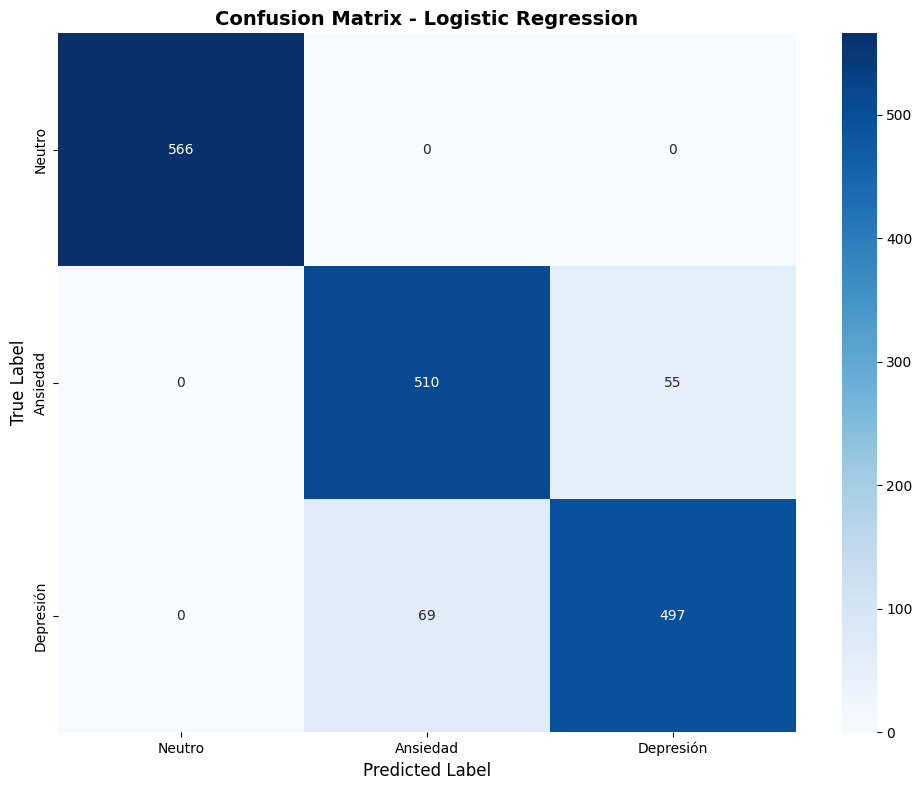

In [6]:
# ============================================
# MODELO 1: LOGISTIC REGRESSION
# ============================================

print("\n" + "=" * 70)
print("MODELO 1: LOGISTIC REGRESSION")
print("=" * 70)

print("\nEntrenando Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    class_weight='balanced',  # Maneja desbalance automáticamente
    solver='lbfgs',
    multi_class='multinomial'
)

lr_model.fit(X_train_tfidf, y_train)
print("✓ Modelo entrenado")

# Evaluar en validation
print("\nEvaluando en Validation Set...")
lr_val_results = evaluate_model(lr_model, X_val_tfidf, y_val, "Logistic Regression (Val)")
print_results(lr_val_results)

# Evaluar en test
print("\nEvaluando en Test Set...")
lr_test_results = evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression (Test)")
print_results(lr_test_results)

# Confusion matrix
plot_confusion_matrix(y_test, lr_test_results['predictions'], 
                     "Logistic Regression", 
                     "confusion_matrix_logistic_regression.png")



MODELO 2: MULTINOMIAL NAIVE BAYES

Entrenando Naive Bayes...
✓ Modelo entrenado

Evaluando en Validation Set...

RESULTADOS: Naive Bayes (Val)

Métricas Generales:
  Accuracy:  0.8939
  Precision: 0.8946
  Recall:    0.8939
  F1-Score:  0.8939

Métricas por Clase:

  Neutro:
    Precision: 1.0000
    Recall:    1.0000
    F1-Score:  1.0000
    Support:   565

  Ansiedad:
    Precision: 0.8601
    Recall:    0.8145
    F1-Score:  0.8367
    Support:   566

  Depresión:
    Precision: 0.8238
    Recall:    0.8675
    F1-Score:  0.8451
    Support:   566

Evaluando en Test Set...

RESULTADOS: Naive Bayes (Test)

Métricas Generales:
  Accuracy:  0.9051
  Precision: 0.9052
  Recall:    0.9051
  F1-Score:  0.9051

Métricas por Clase:

  Neutro:
    Precision: 1.0000
    Recall:    1.0000
    F1-Score:  1.0000
    Support:   566

  Ansiedad:
    Precision: 0.8620
    Recall:    0.8513
    F1-Score:  0.8566
    Support:   565

  Depresión:
    Precision: 0.8534
    Recall:    0.8640
    F1-Sc

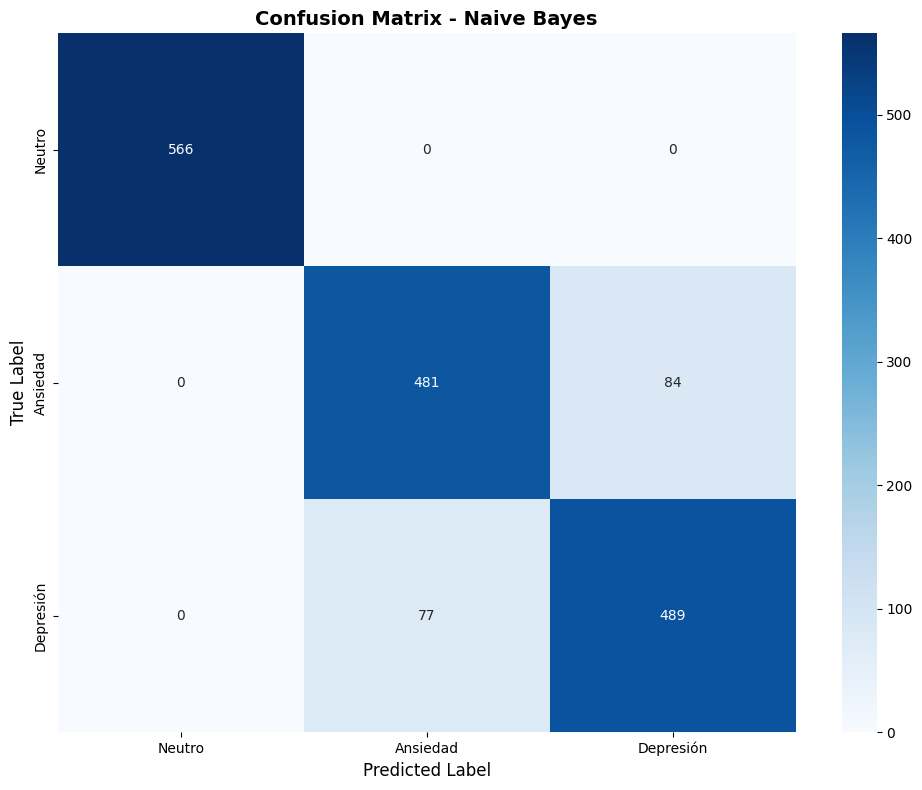

In [7]:
# ============================================
# MODELO 2: NAIVE BAYES
# ============================================

print("\n" + "=" * 70)
print("MODELO 2: MULTINOMIAL NAIVE BAYES")
print("=" * 70)

print("\nEntrenando Naive Bayes...")
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)
print("✓ Modelo entrenado")

# Evaluar en validation
print("\nEvaluando en Validation Set...")
nb_val_results = evaluate_model(nb_model, X_val_tfidf, y_val, "Naive Bayes (Val)")
print_results(nb_val_results)

# Evaluar en test
print("\nEvaluando en Test Set...")
nb_test_results = evaluate_model(nb_model, X_test_tfidf, y_test, "Naive Bayes (Test)")
print_results(nb_test_results)

# Confusion matrix
plot_confusion_matrix(y_test, nb_test_results['predictions'],
                     "Naive Bayes",
                     "confusion_matrix_naive_bayes.png")


MODELO 3: RANDOM FOREST

Entrenando Random Forest...
✓ Modelo entrenado

Evaluando en Validation Set...

RESULTADOS: Random Forest (Val)

Métricas Generales:
  Accuracy:  0.9187
  Precision: 0.9196
  Recall:    0.9187
  F1-Score:  0.9189

Métricas por Clase:

  Neutro:
    Precision: 1.0000
    Recall:    0.9876
    F1-Score:  0.9938
    Support:   565

  Ansiedad:
    Precision: 0.8962
    Recall:    0.8693
    F1-Score:  0.8825
    Support:   566

  Depresión:
    Precision: 0.8627
    Recall:    0.8993
    F1-Score:  0.8806
    Support:   566

Evaluando en Test Set...

RESULTADOS: Random Forest (Test)

Métricas Generales:
  Accuracy:  0.9210
  Precision: 0.9220
  Recall:    0.9210
  F1-Score:  0.9213

Métricas por Clase:

  Neutro:
    Precision: 0.9964
    Recall:    0.9788
    F1-Score:  0.9875
    Support:   566

  Ansiedad:
    Precision: 0.9004
    Recall:    0.8796
    F1-Score:  0.8899
    Support:   565

  Depresión:
    Precision: 0.8693
    Recall:    0.9046
    F1-Score:

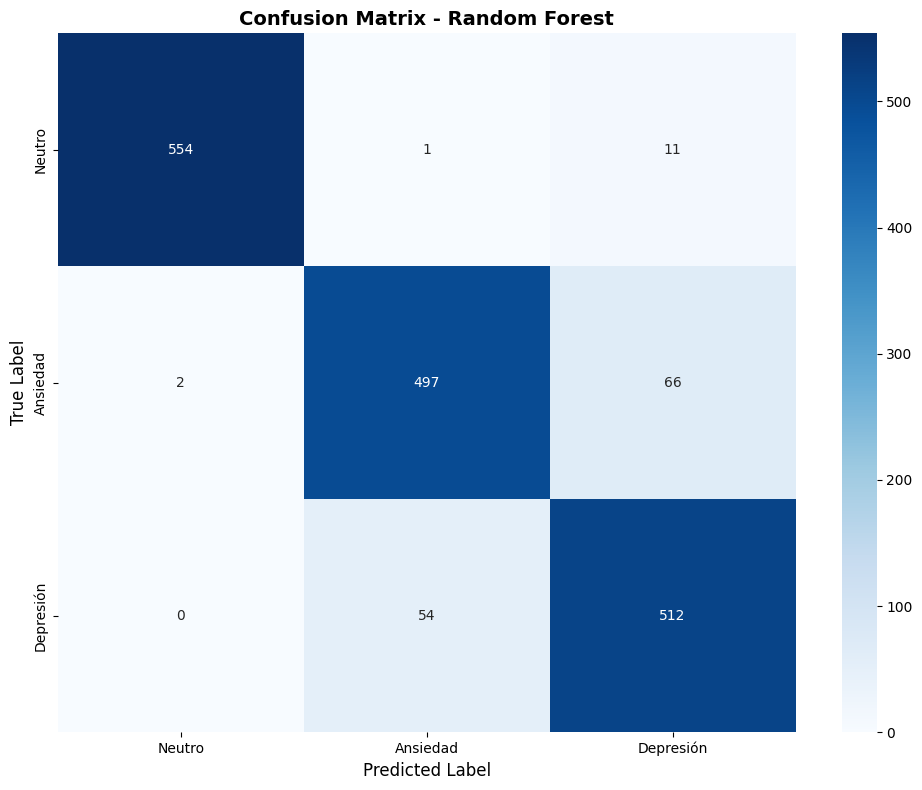

In [8]:
# MODELO 3: RANDOM FOREST (Opcional)
# ============================================

print("\n" + "=" * 70)
print("MODELO 3: RANDOM FOREST")
print("=" * 70)

print("\nEntrenando Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train_tfidf, y_train)
print("✓ Modelo entrenado")

# Evaluar en validation
print("\nEvaluando en Validation Set...")
rf_val_results = evaluate_model(rf_model, X_val_tfidf, y_val, "Random Forest (Val)")
print_results(rf_val_results)

# Evaluar en test
print("\nEvaluando en Test Set...")
rf_test_results = evaluate_model(rf_model, X_test_tfidf, y_test, "Random Forest (Test)")
print_results(rf_test_results)

# Confusion matrix
plot_confusion_matrix(y_test, rf_test_results['predictions'],
                     "Random Forest",
                     "confusion_matrix_random_forest.png")


COMPARACIÓN DE MODELOS

--- Comparación en Test Set ---
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.926930   0.927091 0.926930  0.926919
        Naive Bayes  0.905127   0.905162 0.905127  0.905123
      Random Forest  0.921037   0.922024 0.921037  0.921347


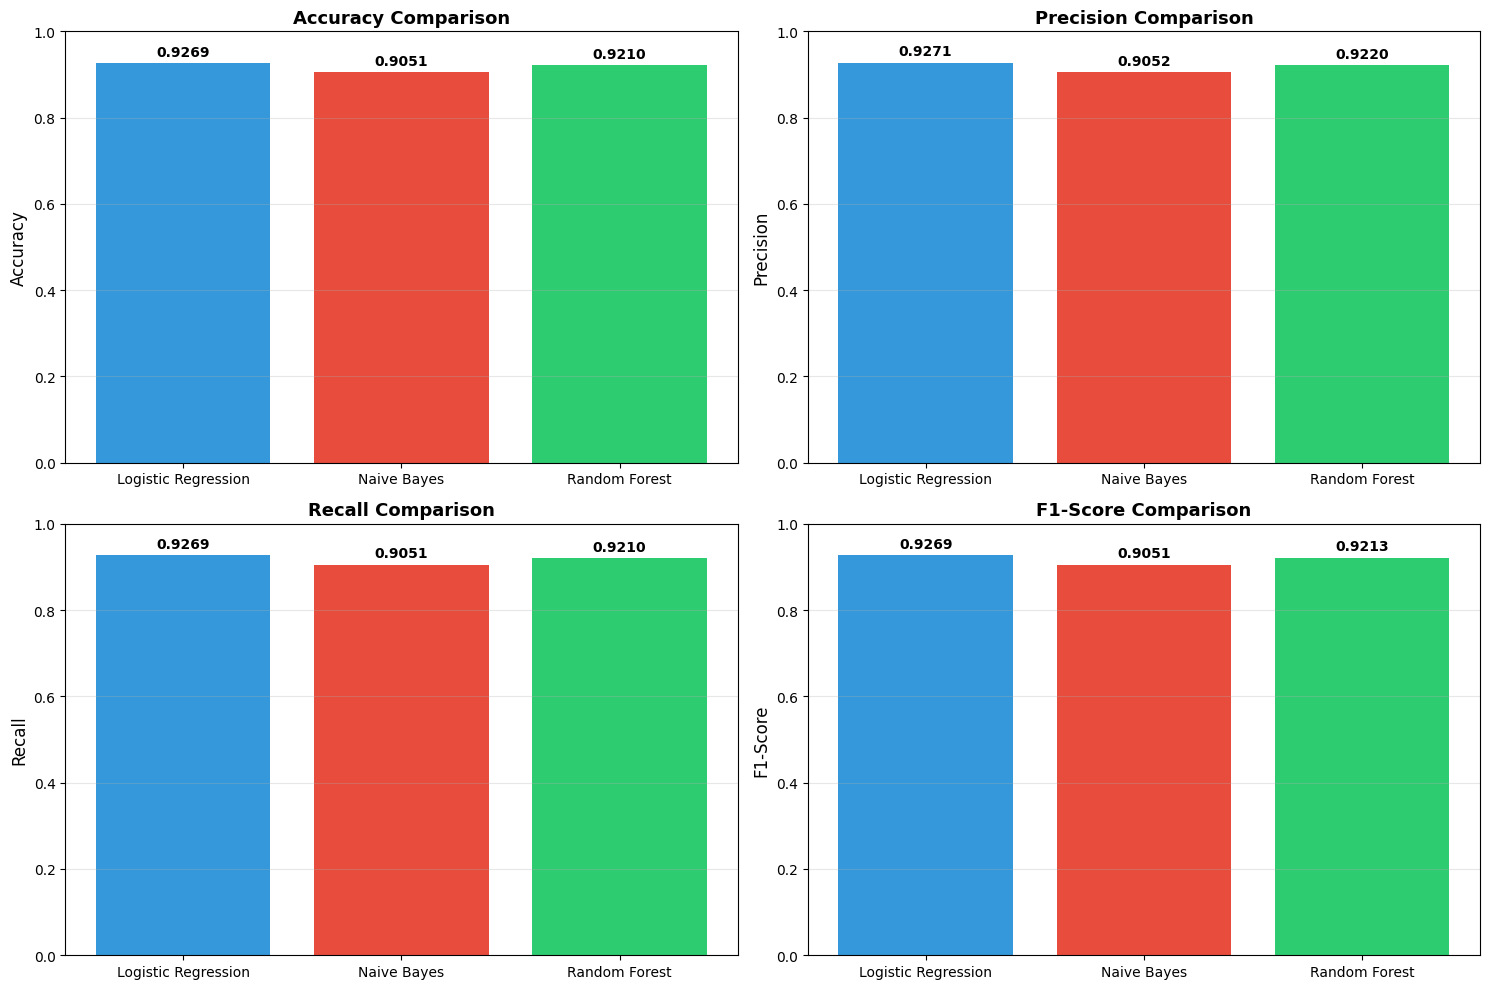

In [9]:
# ============================================
# COMPARACIÓN DE MODELOS
# ============================================

print("\n" + "=" * 70)
print("COMPARACIÓN DE MODELOS")
print("=" * 70)

# Tabla comparativa
comparison_data = {
    'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest'],
    'Accuracy': [
        lr_test_results['accuracy'],
        nb_test_results['accuracy'],
        rf_test_results['accuracy']
    ],
    'Precision': [
        lr_test_results['precision'],
        nb_test_results['precision'],
        rf_test_results['precision']
    ],
    'Recall': [
        lr_test_results['recall'],
        nb_test_results['recall'],
        rf_test_results['recall']
    ],
    'F1-Score': [
        lr_test_results['f1_score'],
        nb_test_results['f1_score'],
        rf_test_results['f1_score']
    ]
}
comparison_df = pd.DataFrame(comparison_data)
print("\n--- Comparación en Test Set ---")
print(comparison_df.to_string(index=False))

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Model'], values, color=['#3498db', '#e74c3c', '#2ecc71'])
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Añadir valores en barras
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [10]:
# ============================================
# SELECCIONAR MEJOR MODELO
# ============================================

print("\n" + "=" * 70)
print("SELECCIÓN DEL MEJOR MODELO")
print("=" * 70)

# Determinar mejor modelo por F1-Score
best_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_f1 = comparison_df.loc[best_idx, 'F1-Score']

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")

# Seleccionar el modelo ganador
if best_model_name == 'Logistic Regression':
    best_model = lr_model
    best_results = lr_test_results
elif best_model_name == 'Naive Bayes':
    best_model = nb_model
    best_results = nb_test_results
else:
    best_model = rf_model
    best_results = rf_test_results


SELECCIÓN DEL MEJOR MODELO

🏆 MEJOR MODELO: Logistic Regression
   F1-Score: 0.9269


In [11]:
# ============================================
# GUARDAR MEJOR MODELO
# ============================================

print("\n" + "=" * 70)
print("GUARDANDO MODELO FINAL")
print("=" * 70)

# Guardar modelo
model_path = f"{OUTPUT_DIR}best_model.pkl"
joblib.dump(best_model, model_path)
print(f"✓ Modelo guardado: {model_path}")

# Guardar metadata
metadata = {
    'model_name': best_model_name,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'accuracy': best_results['accuracy'],
    'precision': best_results['precision'],
    'recall': best_results['recall'],
    'f1_score': best_results['f1_score'],
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'vocabulary_size': len(feature_names),
    'label_mapping': LABEL_NAMES
}

metadata_path = f"{OUTPUT_DIR}model_metadata.pkl"
joblib.dump(metadata, metadata_path)
print(f"✓ Metadata guardada: {metadata_path}")


GUARDANDO MODELO FINAL
✓ Modelo guardado: /Users/angiediaz/Desktop/Proyecto ML/Models/best_model.pkl
✓ Metadata guardada: /Users/angiediaz/Desktop/Proyecto ML/Models/model_metadata.pkl


In [12]:
# ============================================
# REPORTE FINAL
# ============================================

print("\n" + "=" * 70)
print("GENERANDO REPORTE FINAL")
print("=" * 70)

report = f"""
{'='*70}
REPORTE DE ENTRENAMIENTO - MOODBOT
{'='*70}

FECHA: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

{'='*70}
1. DATASET
{'='*70}

Training:   {len(df_train)} muestras
Validation: {len(df_val)} muestras
Test:       {len(df_test)} muestras
Total:      {len(df_train) + len(df_val) + len(df_test)} muestras

Distribución de Labels (Test):
{pd.Series(y_test).value_counts().sort_index().to_string()}

{'='*70}
2. VECTORIZACIÓN
{'='*70}

Método: TF-IDF
Features: {len(feature_names)}
Max Features: 5000
N-grams: (1, 2) - unigramas y bigramas
Min DF: 2
Max DF: 0.8

{'='*70}
3. MODELOS ENTRENADOS
{'='*70}

{comparison_df.to_string(index=False)}

{'='*70}
4. MEJOR MODELO
{'='*70}

Modelo Seleccionado: {best_model_name}

Métricas en Test Set:
- Accuracy:  {best_results['accuracy']:.4f}
- Precision: {best_results['precision']:.4f}
- Recall:    {best_results['recall']:.4f}
- F1-Score:  {best_results['f1_score']:.4f}

Métricas por Clase:
"""

for label_id, label_name in LABEL_NAMES.items():
    if label_name in best_results['report']:
        metrics = best_results['report'][label_name]
        report += f"""
{label_name}:
  Precision: {metrics['precision']:.4f}
  Recall:    {metrics['recall']:.4f}
  F1-Score:  {metrics['f1-score']:.4f}
  Support:   {int(metrics['support'])}
"""

report += f"""
{'='*70}
5. ARCHIVOS GENERADOS
{'='*70}

Modelos:
- {model_path}
- {vectorizer_path}
- {metadata_path}

Visualizaciones:
- {RESULTS_DIR}confusion_matrix_logistic_regression.png
- {RESULTS_DIR}confusion_matrix_naive_bayes.png
- {RESULTS_DIR}confusion_matrix_random_forest.png
- {RESULTS_DIR}model_comparison.png

{'='*70}
6. PRÓXIMOS PASOS
{'='*70}

✓ Modelo entrenado y guardado
✓ Listo para deployment

Siguiente fase (22-23 nov):
1. Crear API con Flask/FastAPI
2. Endpoint /predict
3. Integrar con frontend (Vercel)

Para deployment necesitarás:
- best_model.pkl
- tfidf_vectorizer.pkl
- model_metadata.pkl

{'='*70}
FIN DEL REPORTE
{'='*70}
"""

report_path = f"{RESULTS_DIR}training_report.txt"
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report)
print(f"✓ Reporte guardado: {report_path}")

# ============================================
# RESUMEN FINAL
# ============================================

print("\n" + "=" * 70)
print("✅ ENTRENAMIENTO COMPLETADO")
print("=" * 70)

print(f"\n🎯 Resumen:")
print(f"   • Mejor modelo: {best_model_name}")
print(f"   • F1-Score: {best_f1:.4f}")
print(f"   • Accuracy: {best_results['accuracy']:.4f}")

print(f"\n📁 Archivos guardados en:")
print(f"   Models/: {OUTPUT_DIR}")
print(f"   Results/: {RESULTS_DIR}")

print(f"\n✅ MODELO LISTO PARA DEPLOYMENT")
print(f"   Archivos necesarios:")
print(f"   1. best_model.pkl")
print(f"   2. tfidf_vectorizer.pkl")
print(f"   3. model_metadata.pkl")

print(f"\n📅 Siguiente fase (22-23 nov):")
print(f"   → Crear API con Flask")
print(f"   → Endpoint /predict")
print(f"   → Integrar con chatbot")

print("\n" + "=" * 70)
print("🚀 ¡FASE DE ENTRENAMIENTO COMPLETADA!")
print("=" * 70)


GENERANDO REPORTE FINAL
✓ Reporte guardado: /Users/angiediaz/Desktop/Proyecto ML/Results/training_report.txt

✅ ENTRENAMIENTO COMPLETADO

🎯 Resumen:
   • Mejor modelo: Logistic Regression
   • F1-Score: 0.9269
   • Accuracy: 0.9269

📁 Archivos guardados en:
   Models/: /Users/angiediaz/Desktop/Proyecto ML/Models/
   Results/: /Users/angiediaz/Desktop/Proyecto ML/Results/

✅ MODELO LISTO PARA DEPLOYMENT
   Archivos necesarios:
   1. best_model.pkl
   2. tfidf_vectorizer.pkl
   3. model_metadata.pkl

📅 Siguiente fase (22-23 nov):
   → Crear API con Flask
   → Endpoint /predict
   → Integrar con chatbot

🚀 ¡FASE DE ENTRENAMIENTO COMPLETADA!
